# **Putative Disease Genes Identification and Drugs Repurposing for Miller-Dieker syndrome**

BIOINFORMATICS AND NETWORK MEDICINE a.y 2022-2023  
La Sapienza University of Rome  
ARTIFICIAL INTELLIGENDE AND ROBOTICS  
Course of Data Science  
Salvatore Falciglia, Gerardo Loffredo  
  


*Code inspired from Alessandro Quattrociocchi and Tansel Simsek GitHub repository, Bioinformatics and Network Medicine a.y. 2021-2022.

In [ ]:
%load_ext autoreload
%autoreload 2

import networkx as nx

import pandas as pd
from code_py.DIAMOnD import *
from code_py.backbone import Human_Genes_Graph_Analysis
import markov_clustering as mc
import networkx.algorithms.community as nx_comm
from scipy.stats import hypergeom

from joblib import Parallel, delayed
from tqdm import tqdm

sys_path = '/home/pc/Desktop/millerdiekersyndrome/'

## 1. PPI and GDA data gathering and interactome reconstruction

In [ ]:
disease_code = "C0265219"
hga = Human_Genes_Graph_Analysis(sys_path,disease_ID = disease_code)
hga.create_empty_dataframe(name = disease_code)

#### 1.1 -- Open Interactome from CYTOSCAPE

In [ ]:
# Open the (LCC) PPI Network of the interactome from Cytoscape
hs_putative_genes = hga.openfromcytoscape_dataset('Biogrid_4.4.216.txt')
print(len(hs_putative_genes))

1030751


In [ ]:
# Create the sub graph, adj matrix, nodes and edges of LCC 
pgenes_sub_graph,pgenes_adj,pnodes,pedges = hga.LCC_to_adj(hs_putative_genes)

Number of nodes: 19729
Number of edges: 769192
19724
Graph with 19724 nodes and 769187 edges


/home/pc/Desktop/millerdiekersyndrome/code_py/backbone.py:106: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.LCC_sub_graph_adj = nx.adjacency_matrix(self.LCC_sub_graph)


Graph with 19724 nodes and 766017 edges


In [ ]:
from_adjmatrix_to_graph = {}
pgenes_sub_graph_nodeslist = list(pgenes_sub_graph.nodes)
for i in range(len(pgenes_sub_graph_nodeslist)):
    from_adjmatrix_to_graph[pgenes_sub_graph_nodeslist[i]] = i

In [ ]:
print(from_adjmatrix_to_graph['PAFAH1B1'])

4534


#### 1.2 -- Filtering Disease Genes


In [ ]:
# Associated Disease-Genes from DisGeNET
hs_disease_genes_df,hs_disease_genes = hga.query_disease_genes("C0265219_disease_gda_summary.tsv")

Found 182 disease genes in Miller Dieker syndrome


In [ ]:
# Open the (LCC) Network of Disease Genes presented in the Interactome
hs_disease_genes_inside_interactome = hga.openfromcytoscape_dataset('diseaseLCC_edgetable.txt')
print(len(hs_disease_genes_inside_interactome))

438


In [ ]:
# Create the sub graph, adj matrix, nodes and edges of LCC 
disease_genes_sub_graph, eig_centrality, btw_centrality, cls_centrality, degree = hga.LCC_to_adj(hs_disease_genes_inside_interactome,
                                                                                                 extract_measures=True)

Number of nodes: 124
Number of edges: 438
124
Graph with 124 nodes and 438 edges
Graph with 124 nodes and 438 edges


In [ ]:
# Extract measures and save on .csv file
diseaseLCC_measures = {}
for k,v in degree:
    diseaseLCC_measures[k] = [degree[k],
                              btw_centrality[k], 
                              eig_centrality[k], 
                              cls_centrality[k], 
                              btw_centrality[k]/degree[k]]
df_diseaseLCC_measures = pd.DataFrame.from_dict(diseaseLCC_measures,
                                                orient='index',
                                                columns=['Degree', 
                                                         'Betweenness', 
                                                         'Eigenvector Centrality', 
                                                         'Closeness Centrality', 
                                                         'Ratio Btw/Degree'])
df_diseaseLCC_measures.sort_values(by='Ratio Btw/Degree', ascending=False).to_csv('/home/pc/Desktop/millerdiekersyndrome/data/diseaseLCC_measures.csv')

## 2. Putative Disease Genes Identification Algorithms

#### 2.1 -- Cross Validation

In [ ]:
# Cross-Validation
ds_genes_train,ds_genes_test = hga.KFold_CV(hs_disease_genes,n_folds=5,shuffle_flag=True)

In [ ]:
for ds_gene in ds_genes_train[4]:
    print(ds_gene)

PAFAH1B1
PAFAH1B2
PAFAH1B4
PAFAH1B5
PAFAH1B7
PAFAH1B8
PAFAH1B9
PAFAH1B10
PAFAH1B11
FANCD2
UBE2T
FANCG
FANCF
FANCA
FANCC
RAD51
SLX4
BRIP1
CTC1
PALB2
MAD2L2
BRCA2
XRCC2
FANCE
BLM
DPH1
TP53
SGCE
EPO
FLT3
CD34
SF3B1
KMT2A
RPS14
BCR
MECP2
RN7SL263P
JAK2
CSF3
U2AF1
CDKN1C
GFI1
DERL1
CDKN2B
LINC01194
DDX41
ASXL1
PLCB1
PIGA
CSF2
MECOM
SRSF2
GORASP1
MRPL28
WT1
BCL2
PRDM16
RELA
ROBO2
SUB1
RARA
H3P10
QRSL1
MAPK8
PSMB6
MSC
PTEN
H3P9
LSM2
PARK7
RAP1GAP
CCND1
WNK1
NDEL1
ESPL1
CDR3
CAMP
STUB1
U2AF1L5
IKBKG
CDKN1B
CDKN1A
CD14
ABCG2
PSC
BAALC
CIB1
STAT3
SYT1
TCF4
THBS1
TK2
TLR2
CD52
WNT1
YY1
CD38
SGCZ
ABR
NXT1
GSTM1
GSTT1
HOXD13
HRAS
HSPA9
HTC2
DLL1
DNAI1
GEM
EZH2
TOR1A
FGF1
TBC1D9
PRAME
CTAG1A
ABL1
SETBP1
GATA2
COL6A4P1
IL2RA
MPV17
MT1E
MVD
NCAM1
ATM
NUP98
CRK
PLCE1
ABCB1
PLK1
CD200
MMP9
MMP1
CXCL8
CXCR2
IRF1
ISG20
ITGB4
CUX1
KIR3DL1
KRAS
MCL1
PDIK1L
MLF1
CTAG1B
TET2


### 2.2 -- DIAMOnD Algorithm


In [ ]:
results_df = hga.return_metrics("DIAMOnD", pgenes_sub_graph, hs_disease_genes, ds_genes_train, ds_genes_test, save_dataframe=True)
results_df[["@",'Metric',"DIAMOnD"]]

DIAMOnD(): ignoring 11 of 145 seed genes that are not in the network
DIAMOnD(): ignoring 11 of 145 seed genes that are not in the network
DIAMOnD(): ignoring 13 of 146 seed genes that are not in the network
DIAMOnD(): ignoring 15 of 146 seed genes that are not in the network
DIAMOnD(): ignoring 14 of 146 seed genes that are not in the network


,@,Metric,DIAMOnD
0,,P,5.6 ± 5.18
1,50,R,7.66 ± 7.06
2,,F1,8.09 ± 5.49
3,,nDCG,6.98 ± 8.08
4,,P,7.78 ± 9.3
5,n/10,R,3.81 ± 4.54
6,,F1,8.53 ± 5.54
7,,nDCG,9.38 ± 13.65
8,,P,5.33 ± 5.12
9,n/4,R,6.55 ± 6.23


### 2.3 -- DiaBLE Algorithm

In [ ]:
results_df = hga.return_metrics("DiaBLE", pgenes_sub_graph, hs_disease_genes, ds_genes_train, ds_genes_test, save_dataframe=True)
results_df[["@",'Metric',"DiaBLE"]]

DiaBLE(): ignoring 11 of 145 seed genes that are not in the network
DiaBLE(): ignoring 11 of 145 seed genes that are not in the network
DiaBLE(): ignoring 13 of 146 seed genes that are not in the network
DiaBLE(): ignoring 15 of 146 seed genes that are not in the network
DiaBLE(): ignoring 14 of 146 seed genes that are not in the network


,@,Metric,DiaBLE
0,,P,5.6 ± 5.18
1,50,R,7.66 ± 7.06
2,,F1,8.09 ± 5.49
3,,nDCG,6.41 ± 6.96
4,,P,7.78 ± 9.3
5,n/10,R,3.81 ± 4.54
6,,F1,8.53 ± 5.54
7,,nDCG,8.26 ± 11.29
8,,P,5.33 ± 5.12
9,n/4,R,6.55 ± 6.23


### 2.4 -- Cytoscape

In [ ]:
results_df =hga.return_metrics("Cytoscape", pgenes_sub_graph, hs_disease_genes, ds_genes_train, ds_genes_test, save_dataframe=True, diffusion_time='diffusion_time_0.002')
results_df[["@",'Metric',"Cytoscape"]]

,@,Metric,Cytoscape
0,,P,0.0 ± 0.0
1,50,R,0.0 ± 0.0
2,,F1,0.0 ± 0.0
3,,nDCG,0.0 ± 0.0
4,,P,0.0 ± 0.0
5,n/10,R,0.0 ± 0.0
6,,F1,0.0 ± 0.0
7,,nDCG,0.0 ± 0.0
8,,P,0.0 ± 0.0
9,n/4,R,0.0 ± 0.0


In [ ]:
results_df =hga.return_metrics("Cytoscape", pgenes_sub_graph, hs_disease_genes, ds_genes_train, ds_genes_test, save_dataframe=True, diffusion_time='diffusion_time_0.005')
results_df[["@",'Metric',"Cytoscape"]]

,@,Metric,Cytoscape
0,,P,0.0 ± 0.0
1,50,R,0.0 ± 0.0
2,,F1,0.0 ± 0.0
3,,nDCG,0.0 ± 0.0
4,,P,0.0 ± 0.0
5,n/10,R,0.0 ± 0.0
6,,F1,0.0 ± 0.0
7,,nDCG,0.0 ± 0.0
8,,P,0.0 ± 0.0
9,n/4,R,0.0 ± 0.0


In [ ]:
results_df =hga.return_metrics("Cytoscape", pgenes_sub_graph, hs_disease_genes, ds_genes_train, ds_genes_test, save_dataframe=True, diffusion_time='diffusion_time_0.01')
results_df[["@",'Metric',"Cytoscape"]]

,@,Metric,Cytoscape
0,,P,0.0 ± 0.0
1,50,R,0.0 ± 0.0
2,,F1,0.0 ± 0.0
3,,nDCG,0.0 ± 0.0
4,,P,0.0 ± 0.0
5,n/10,R,0.0 ± 0.0
6,,F1,0.0 ± 0.0
7,,nDCG,0.0 ± 0.0
8,,P,0.0 ± 0.0
9,n/4,R,0.0 ± 0.0


## 3. [OPTIONAL] Putative disease genes identification using community detection algorithms

### 3.1 -- MCL Algorithm

In [ ]:
# perform clustering using different inflation values from 1.8 and 2.7
# for each clustering run, calculate the modularity
for inflation in [i / 10 for i in range(18, 27)]:
    result = mc.run_mcl(pgenes_adj, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

inflation: 1.8 modularity: 0.8508013712329157
inflation: 1.9 modularity: 0.8084824790175417
inflation: 2.0 modularity: 0.764663222543563
inflation: 2.1 modularity: 0.7178722748463001
inflation: 2.2 modularity: 0.6699262538505127
inflation: 2.3 modularity: 0.6248664083105782
inflation: 2.4 modularity: 0.5861435724167875
inflation: 2.5 modularity: 0.5509333250283788
inflation: 2.6 modularity: 0.5194415441714865


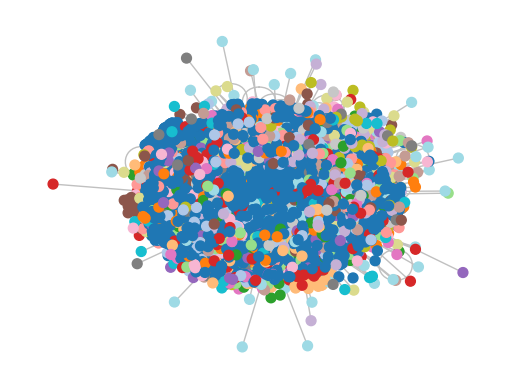

In [ ]:
# cluster using the optimized cluster inflation value
result = mc.run_mcl(pgenes_adj, inflation=1.8) # value still to find
clusters = mc.get_clusters(result)
mc.draw_graph(pgenes_adj, clusters, node_size=50, with_labels=False, edge_color="silver")

In [ ]:
# Within the clusters (list) check for all those communities with 10<=s<=1000
list_of_communities_MCL = []
for cluster in clusters:
    if len(cluster) >= 10 and len(cluster) <= 1000:
        list_of_communities_MCL.append(cluster)
        
print("(MCL ALGORITHM) Number of communities: {}".format(len(list_of_communities_MCL)))

(MCL ALGORITHM) Number of communities: 153


### 3.2 -- Louvain Algorithm

In [ ]:
list_of_communities = nx_comm.louvain_communities(pgenes_sub_graph, resolution=1, seed=123) #return list of sets

In [ ]:
# Within the list_of_commuties check for all those communities with 10<=s<=1000
list_of_communities_LOUVAIN = []
for cluster in list_of_communities:
    if len(cluster) >= 10 and len(cluster) <= 1000:
        list_of_communities_LOUVAIN.append(cluster)

print("(LOUVAIN ALGORITHM) Number of communities: {}".format(len(list_of_communities_LOUVAIN)))

(LOUVAIN ALGORITHM) Number of communities: 3


### 3.3 -- Hypergeometric Test

In [ ]:
# Input values for the hypergeometric test
# N = number of total genes; 
# K = total number of disease genes in the interactome;
# n = number of genes in the community (for each community); 
# k = number of known disease genes in the community (for each community)

N = pgenes_sub_graph.number_of_nodes()
K = len(hs_disease_genes)

# Hypergeometric test MCL communities
print("Hypergeometric Test p-value for MCL communities:\n")
pval_list_of_communities_MCL = []
i = 0
for community in list_of_communities_MCL:
    # compute n
    n = len(community)
    # compute k
    k = 0
    for dgene in disease_genes_sub_graph:
        dgene_num = from_adjmatrix_to_graph[dgene]
        if dgene_num in community: 
            k = k + 1
    # compute pval
    pval = hypergeom.sf(k-1, N, K, n)
    pval_list_of_communities_MCL.append({"index":i, "pval":pval, "n":n, "k":k})
    i = i + 1
    
pval_list_of_communities_MCL_sorted = sorted(pval_list_of_communities_MCL, key=lambda d: d['pval'])    
for e in pval_list_of_communities_MCL_sorted:
    print('community index: {}, n = {}, k = {}, p-value = {}'.format(e['index'], e['n'], e['k'], e['pval']))

# Hypergeometric test LOUVAIN communities
print("\nHypergeometric Test p-value for LOUVAIN communities:\n")
pval_list_of_communities_LOUVAIN = []
i = 0
for community in list_of_communities_LOUVAIN:
    # compute n
    n = len(community)
    # compute k
    k = 0
    for dgene in hs_disease_genes:
        if dgene in community:
            k = k + 1
    # compute pval
    pval = hypergeom.sf(k-1, N, K, n)
    pval_list_of_communities_LOUVAIN.append({"index":i, "pval":pval, "n":n, "k":k})
    i = i + 1
    
pval_list_of_communities_LOUVAIN_sorted = sorted(pval_list_of_communities_LOUVAIN, key=lambda d: d['pval'])    
for e in pval_list_of_communities_LOUVAIN_sorted:
    print('community index: {}, n = {}, k = {}, p-value = {}'.format(e['index'], e['n'], e['k'], e['pval']))

Hypergeometric Test p-value for MCL communities:

community index: 102, n = 20, k = 4, p-value = 3.027344946994569e-05
community index: 39, n = 13, k = 2, p-value = 0.00617770475730375
community index: 31, n = 54, k = 2, p-value = 0.08875994012279693
community index: 16, n = 120, k = 3, p-value = 0.09965465646607079
community index: 7, n = 19, k = 1, p-value = 0.16156152665232024
community index: 96, n = 27, k = 1, p-value = 0.2215578118771508
community index: 104, n = 27, k = 1, p-value = 0.2215578118771508
community index: 129, n = 37, k = 1, p-value = 0.29058263401064066
community index: 60, n = 42, k = 1, p-value = 0.3227768062885171
community index: 6, n = 69, k = 1, p-value = 0.47310407890688505
community index: 1, n = 783, k = 7, p-value = 0.5876348547064801
community index: 26, n = 432, k = 3, p-value = 0.7644577693126674
community index: 28, n = 215, k = 1, p-value = 0.8652089437232613
community index: 40, n = 223, k = 1, p-value = 0.874947980735136
community index: 27, n = 44

In [ ]:
# We need to put a threshold on pvalues in order to determine the putative disease modules
# and add them into the list predicted_disease_modules
threshold_pval = 0.1

predicted_disease_modules_MCL = []
for elem in pval_list_of_communities_MCL_sorted:
    if elem['pval']<=threshold_pval:
        predicted_disease_modules_MCL.append(elem)
print('MCL analysis predicted n.{} disease modules.'.format(len(predicted_disease_modules_MCL)))

predicted_disease_modules_LOUVAIN = []
for elem in pval_list_of_communities_LOUVAIN_sorted:
    if elem['pval']<=threshold_pval:
        predicted_disease_modules_LOUVAIN.append(elem)
print('LOUVAIN analysis predicted n.{} disease modules.'.format(len(predicted_disease_modules_LOUVAIN)))

# Retrieve all new genes ('new' = not within the 182 nown disease genes) inside all the
# communities in the list predicted_disease_modules
if len(predicted_disease_modules_MCL) != 0:
    cnt = 0
    predicted_disease_genes_MCL = []
    for pd_module in predicted_disease_modules_MCL:
        community = list_of_communities_MCL[pd_module['index']]
        for gene in pgenes_sub_graph:
            if gene not in disease_genes_sub_graph:
                gene_num = from_adjmatrix_to_graph[gene]
                if gene_num in community:
                    cnt += 1
                    predicted_disease_genes_MCL.append(gene)
    print('\nList of (n.{}) predicted disease genes with MCL Algorithm:'.format(len(predicted_disease_genes_MCL)))
    for elem in predicted_disease_genes_MCL:
        print(elem)
else:
    print('\nNo predicted disease genes with MCL Algorithm.')
    
if len(predicted_disease_modules_LOUVAIN) != 0:
    cnt = 0
    predicted_disease_genes_LOUVAIN = []
    for pd_module in predicted_disease_modules_LOUVAIN:
        community = list_of_communities_LOUVAIN[pd_module['index']]
        for gene in pgenes_sub_graph:
            if gene not in disease_genes_sub_graph:
                if gene in community:
                    cnt += 1
                    predicted_disease_genes_LOUVAIN.append(gene)
    print('\nList of (n.{}) predicted disease genes with LOUVAIN Algorithm:'.format(len(predicted_disease_genes_LOUVAIN)))
    for elem in predicted_disease_genes_LOUVAIN:
        print(elem)
else:
    print('\nNo predicted disease genes with LOUVAIN Algorithm.')
    

MCL analysis predicted n.4 disease modules.
LOUVAIN analysis predicted n.0 disease modules.

List of (n.196) predicted disease genes with MCL Algorithm:
RMI1
FANCL
HES1
FANCM
C17orf70
C19orf40
FANCB
APITD1
STRA13
RMI2
C1orf86
SPIDR
KLHDC8B
SLC45A3
SHOX
CARD17
CASC5
MDFIC
EXPH5
SVIP
POLN
BPIFB4
LOC101930047
DCST2
GPR179
C11orf80
AQP7P3
TCF3
LYL1
TAL1
ID1
ID2
TCF12
NEUROD1
CBFA2T2
TINAGL1
PCBD2
TWIST2
HAND1
ASCL4
TCF23
NEUROG1
TCF21
CSRP3
MYF5
MYF6
TAL2
MATN1
MATN3
SCX
ASCL3
OLIG2
ID4
TCF24
ATOH8
NHLH2
PDZD4
C2orf49
CYSTM1
ACSL1
ATP11B
LRRN2
CYP3A5
SIGLEC6
NUTM2F
FERD3L
REXO1L6P
ZNF205-AS1
NFAM1
MESP2
MAGEC3
WASF4P
CYP3A7
SPO11
MSGN1
C1orf56
FIGLA
ATOH7
NXPE2
INSR
IGF1R
EGFR
HBEGF
IRS1
MET
FES
ERBB4
WAS
PTK6
GAB1
TNK2
PDGFRB
MATK
ERBB2
ERBB3
IRS2
ITK
DOK1
EPHA3
LSR
ABL2
KIT
EGF
SHB
GRM1
AATK
IL2RB
EPOR
L1CAM
LMTK2
GHR
ANKRD13B
TRIT1
DLGAP4
EPHB6
FRS2
BLNK
GRM7
PTPRJ
SH2B2
TEC
SLA
EPHA2
MST1R
NTRK2
TEK
KCNE1
NCAN
SHC3
SH2B3
SLA2
EREG
LTK
SHD
SHE
TTYH2
SOCS5
KCTD9P2
NLRP10
DDX53
CYLC2
PTK7

## 4. Best algorithm choice and putative disease gene identification

In [ ]:
added_nodes, predicted_nodes = DIAMOnD(G_original=pgenes_sub_graph,
                                       seed_genes=hs_disease_genes,
                                       max_number_of_added_nodes=200,alpha=1,DiaBLE=True)

DiaBLE(): ignoring 16 of 182 seed genes that are not in the network


In [ ]:
for elem in predicted_nodes:
    print(elem)

SPTA1
HSP90AA1
CDK1
SP1
CDK4
KAT2B
AKT1
CTBP1
MDM2
HSPA4
RB1
TP73
MDM4
SKP2
E2F1
CCNA2
CDK2
CREBBP
CCNE1
EP300
SIRT1
CDK6
UHRF2
PCNA
CCNB1
DNMT1
HDAC1
SP3
FOXM1
SMAD3
FOXO1
PML
PARP1
UBE2I
JUN
AR
XRCC6
SMAD2
RUNX2
USP7
SMARCA4
HDAC3
PRKDC
KAT5
NFYB
MRE11A
PPARG
XRCC5
KAT2A
RPA1
BRD4
RAD50
MSH2
RFC1
ATR
HDAC2
WRN
CHEK1
TP53BP1
TOPBP1
MSH6
HSPA8
CSNK2A1
ZEB1
HIST1H3A
CREB1
NFYA
HMGA2
CEBPB
MYC
VHL
FZR1
UHRF1
HIST1H2BB
CDC27
H2AFX
HMGA1
HIST1H4A
SMARCA5
DDB1
ZBTB7A
MTA2
RBBP4
RBBP5
TRIM28
MCM7
ATRX
HCFC1
CTBP2
HIST2H2BE
SMARCC2
POLR2A
TOP1
RFC4
RPA2
TOP2B
GTF2I
MTA1
NUMA1
SMC1A
BARD1
MDC1
SIN3A
RCOR1
SMARCB1
SMARCC1
CHD4
RBBP7
SAP30
CHD3
GATAD2B
MBD3
SMARCA2
ACTL6A
ARID1A
NFATC2
GATAD2A
CIC
SSRP1
SUZ12
CHAF1A
H2AFZ
SUPT16H
EED
GATA4
SIRT6
SMARCD2
H2AFY
SMARCE1
NFATC1
NUCKS1
BAZ1B
TOP2A
CBX3
HIST1H3E
LIG3
HIST1H2AB
HIST3H3
PBRM1
BAZ1A
HIST1H2BG
BRD2
RSF1
CENPA
SMARCA1
BPTF
CBX1
MBD2
C17orf49
BRD3
HMGXB4
TERF2IP
MTA3
SUDS3
LIN9
ARID4B
MTF2
PWWP2A
MYBL2
BRMS1L
SHPRH
ZNF512B
SAP130
BCL11A
SIN

## 5. Drug Repurposing

### 5.1 -- Drug Repurposing for genes directly connected to PAFAH1B1 and YWHAE

In [ ]:
list_from_file = open("data/drugs_associatedto_predicted_genes_directlyconnectedto_PAFAH1B1_YWHAE.txt").readlines()
list_of_drugs_raw = []
for elem in list_from_file:
    list_of_drugs_raw.append(elem[:-1])

In [ ]:
from collections import Counter
drugs_with_occurrences = dict(Counter(list_of_drugs_raw))
drugs_with_occurrences = dict(sorted(drugs_with_occurrences.items(), key=lambda item: item[1], reverse=True))

for drug,v in drugs_with_occurrences.items():
    print(drug, v)

CISPLATIN 6
CHEMBL225519 4
CYC-116 4
DINACICLIB 3
ALSTERPAULLONE 3
KENPAULLONE 3
SP-600125 3
SOTRASTAURIN 3
LAUROGUADINE 3
GW441756X 3
CENISERTIB 3
R-406 3
PF-00562271 3
RG-1530 3
CHEMBL578061 3
PACLITAXEL 3
RESVERATROL 3
DIETHYLSTILBESTROL 3
DAUNORUBICIN HYDROCHLORIDE 3
WORTMANNIN 3
DOXORUBICIN HYDROCHLORIDE 3
HEXACHLOROPHENE 3
DOCETAXEL 3
DOXORUBICIN 3
EPIRUBICIN 3
AG-24322 2
RONICICLIB 2
AT-7519 2
ZOTIRACICLIB 2
ALVOCIDIB 2
CHIR-99021 2
SELICICLIB 2
PHA-793887 2
RGB-286638 2
MILCICLIB 2
AZD-5438 2
RG-547 2
GO-6976 2
BMS-345541 2
LY-2090314 2
CHEMBL541400 2
AZD-1080 2
CLOTRIMAZOLE 2
WITHAFERIN A 2
(RS)-ROSCOVITINE 2
TAE-684 2
ERIBULIN 2
DEXAMETHASONE 2
AZAKENPAULLONE 2
ACETAMINOPHEN 2
CARBOPLATIN 2
LOVASTATIN 2
GSK-269962A 2
VEMURAFENIB 2
NOVOBIOCIN 2
ALISERTIB 2
CETUXIMAB 2
VORINOSTAT 2
ESTRONE 2
AN-9 2
ANTIBIOTIC 2
AZACITIDINE 2
VERAPAMIL 2
OLAPARIB 2
LITHIUM 2
NORDIHYDROGUAIARETIC ACID 2
KEPONE 2
DICHLOROPHEN 2
ZERANOL 2
ZEARALENONE 2
TESTOSTERONE 2
EVEROLIMUS 2
GOSSYPOL 2
GENISTE

### 5.2 -- Drug Repurposing for the first 20 genes coming from DiaBLE Algorithm

In [ ]:
list_from_file = open("data/drugs_associatedto_20_predicted_genes.txt").readlines()
list_of_drugs_raw = []
for elem in list_from_file:
    list_of_drugs_raw.append(elem[:-1])

In [ ]:
from collections import Counter
drugs_with_occurrences = dict(Counter(list_of_drugs_raw))
drugs_with_occurrences = dict(sorted(drugs_with_occurrences.items(), key=lambda item: item[1], reverse=True))

for drug,v in drugs_with_occurrences.items():
    print(drug, v)

SELICICLIB 4
CHEMBL225519 4
CISPLATIN 4
WORTMANNIN 3
AG-24322 3
RONICICLIB 3
AT-7519 3
DINACICLIB 3
ALVOCIDIB 3
PHA-793887 3
RGB-286638 3
MILCICLIB 3
AZD-5438 3
RG-547 3
SOTRASTAURIN 3
LAUROGUADINE 3
CENISERTIB 3
CYC-116 3
PALBOCICLIB 3
DEXAMETHASONE 3
ALPELISIB 3
CHEMBL1797708 3
CHEMBL1797707 3
CHEMBL257748 3
PACLITAXEL 3
CARBOPLATIN 3
BORTEZOMIB 3
TANESPIMYCIN 2
CLOTRIMAZOLE 2
GAMBOGIC ACID 2
THIRAM 2
ZOTIRACICLIB 2
CHIR-99021 2
RIVICICLIB 2
ALSTERPAULLONE 2
KENPAULLONE 2
SP-600125 2
GO-6976 2
BMS-345541 2
GW441756X 2
LY-2090314 2
CHEMBL541400 2
AZD-1080 2
R-406 2
PF-00562271 2
WITHAFERIN A 2
RG-1530 2
CHEMBL578061 2
(RS)-ROSCOVITINE 2
TAE-684 2
TRILACICLIB 2
RIBOCICLIB 2
UCN-01 2
NICOTINE 2
CHEMBL1797711 2
TRIAZOLAM 2
CHEMBL404916 2
EVEROLIMUS 2
RESVERATROL 2
GSK-269962A 2
PICTILISIB 2
LOVASTATIN 2
SIROLIMUS 2
IRINOTECAN 2
TOPOTECAN 2
PEMBROLIZUMAB 2
NIVOLUMAB 2
LARGAZOLE 2
METHOTREXATE 2
GANETESPIB 1
BIIB021 1
RETASPIMYCIN 1
ALVESPIMYCIN 1
ONALESPIB 1
RETASPIMYCIN HYDROCHLORIDE 1
X

## 6. [To do before 5 -we added this] Alternative to EnrichR analysis

### 6.1 -- Searching for nodes (from the 200 predicted) directly connected to PAFAH1B1 and YWHAE directly on Cytoscape

In [ ]:
# I created a .txt file saved on the folder data
list_from_file = open("data/C0265219_predicted_genes_directlyconnectedto_PAFAH1B1_YWHAE.txt").readlines()
list_of_predicted_genes_directlyconnectedto_PAFAH1B1_YWHAE = []
for elem in list_from_file:
    list_of_predicted_genes_directlyconnectedto_PAFAH1B1_YWHAE.append(elem[:-1])
list_of_predicted_genes_directlyconnectedto_PAFAH1B1_YWHAE.append('PAFAH1B1')
list_of_predicted_genes_directlyconnectedto_PAFAH1B1_YWHAE.append('YWHAE')

In [ ]:
N = pgenes_sub_graph.number_of_nodes()
K = len(hs_disease_genes)
# compute n
n = len(list_of_predicted_genes_directlyconnectedto_PAFAH1B1_YWHAE)
# compute k
k = 0
for dgene in hs_disease_genes:
    if dgene in list_of_predicted_genes_directlyconnectedto_PAFAH1B1_YWHAE:
        k = k + 1
# compute pval
pval = hypergeom.sf(k-1, N, K, n)

print('Community of predicted genes directly connected to PAFAH1B1 and YWHAE\n n = {}, k = {}, p-value = {}'.format(n, k, pval))

Community of predicted genes directly connected to PAFAH1B1 and YWHAE
 n = 36, k = 1, p-value = 0.2839634419358911


### 6.2 -- Building on Cytoscape the large connected component associated with the selection of the 182 already known disease genes plus the 36 nodes of the community resulting from the previous analysis 6.1

In [ ]:
# Open the (LCC) Network of Disease Genes presented in the Interactome
hs_disease_genes_inside_interactome = hga.openfromcytoscape_dataset('diseaseLCC_with_directlyconnectedtoPandY.txt')
print(len(hs_disease_genes_inside_interactome))

1422


In [ ]:
# Create the sub graph, adj matrix, nodes and edges of LCC 
disease_genes_sub_graph, eig_centrality, btw_centrality, cls_centrality, degree = hga.LCC_to_adj(hs_disease_genes_inside_interactome,
                                                                                                 extract_measures=True)

Number of nodes: 170
Number of edges: 1422
170
Graph with 170 nodes and 1422 edges
Graph with 170 nodes and 1422 edges


In [ ]:
# Extract measures and save on .csv file
diseaseLCC_measures = {}
for k,v in degree:
    diseaseLCC_measures[k] = [degree[k],
                              btw_centrality[k], 
                              eig_centrality[k], 
                              cls_centrality[k], 
                              btw_centrality[k]/degree[k]]
df_diseaseLCC_measures = pd.DataFrame.from_dict(diseaseLCC_measures,
                                                orient='index',
                                                columns=['Degree', 
                                                         'Betweenness', 
                                                         'Eigenvector Centrality', 
                                                         'Closeness Centrality', 
                                                         'Ratio Btw/Degree'])
df_diseaseLCC_measures.sort_values(by='Ratio Btw/Degree', ascending=False).to_csv('/home/pc/Desktop/millerdiekersyndrome/data/diseaseLCC_with_directlyconnectedtoPandY_measures.csv')